In [56]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import nltk
import lightgbm as lgb

from utils import helper
from utils import DataLoader, DataProcesser

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
label_dic = {1: 'Still', 2: 'Walking', 3: 'Run', 4: 'Bike', 5: 'Car', 6: 'Bus', 7: 'Train', 8: 'Subway'}

# Routine PipLines

In [3]:
col_drop_x = ['time', 'label']
col_label = 'label'
col_drop = ['latitude',
 'longitude',
 'altitude',
 'time_dlt',
 'valid_dlt',
 'east',
 'north',
 'east_dlt',
 'north_dlt',
 'east_speed',
 'north_speed',
 'cells_ctype_mode',
 'speed_dif',
 'speed_dlt',
 'speed'
 ]

In [4]:
data = DataLoader.SHLDataLoader('data/train/', ratio = None)
val = DataLoader.SHLDataLoader('data/validate/', ratio = None)
data.df = pd.read_csv('data/mid_res/20210526_data_df.csv')
val.df = pd.read_csv('data/mid_res/20210526_val_df.csv')

In [95]:
# tmp modeul
data.df['have_loc'] = data.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
data.df['have_gps'] = data.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
data.df['have_wifi'] = data.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
data.df['have_cells'] = data.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

val.df['have_loc'] = val.df.apply(lambda x: 1 if x['accuracy'] > -1 else 0, axis = 1)
val.df['have_gps'] = val.df.apply(lambda x: 1 if x['num_gps'] > 0 else 0, axis = 1)
val.df['have_wifi'] = val.df.apply(lambda x: 1 if x['num_wifi'] > 0 else 0, axis = 1)
val.df['have_cells'] = val.df.apply(lambda x: 1 if x['num_cells'] > 0 else 0, axis = 1)

In [98]:
test_ratio = 0.2
col_label = 'label'
X = data.df.drop(col_drop + col_drop_x, axis = 1).fillna(0)
# X_train, X_test, y_train, y_test = train_test_split(X, data.df[col_label], test_size = test_ratio)
X_train, y_train = X, data.df[col_label]
X_val, y_val = val.df.drop(col_drop + col_drop_x, axis = 1).fillna(0), val.df[col_label]

In [100]:
model_rf = RandomForestClassifier(n_estimators = 20, random_state = 0, max_depth = 8)
model_rf.fit(X_train, y_train)
pred_rf = model_rf.predict(X_val)
pred_prob_rf = model_rf.predict_proba(X_val)

In [101]:
model_bag = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 100, max_samples = 100, bootstrap=True)
model_bag.fit(X_train, y_train)
pred_bag = model_bag.predict(X_val)
pred_prob_bag = model_bag.predict_proba(X_val)

In [102]:
train_data = lgb.Dataset(X_train, label = y_train - 1)
test_data = lgb.Dataset(X_val, label = y_val - 1)
params={
    'learning_rate':0.1,
    'lambda_l1':0.1,
    'lambda_l2':0.2,
    'max_depth':6,
    'objective':'multiclass',
    'num_class':8,  
}
model_lgb = lgb.train(params, train_data, valid_sets = [test_data])
pred_prob_lgb = model_lgb.predict(X_val)
pred_lgb = pred_prob_lgb.argmax(axis = 1) + 1

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026991 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5025
[LightGBM] [Info] Number of data points in the train set: 980527, number of used features: 36
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.081605
[LightGBM] [Info] Start training from score -2.077810
[LightGBM] [Info] Start training from score -3.143871
[LightGBM] [Info] Start training from score -2.122478
[LightGBM] [Info] Start training from

[[17009  7540    14    89     9   688   543  3944]
 [ 4615 17094    98   709   344  1971   830   488]
 [    4   839   446  1465     7     2     8     3]
 [  285   973  1405  7935    47    15    14  1357]
 [  335   337     0  1138 11155  4598  2491   419]
 [  393    79     4    68    52  4933  1707  1942]
 [ 4574    40     0   115  4206  1001 10970   902]
 [  931   534     0    15   230   220  4454 15325]]
              precision    recall  f1-score   support

       Still       0.60      0.57      0.59     29836
     Walking       0.62      0.65      0.64     26149
         Run       0.23      0.16      0.19      2774
        Bike       0.69      0.66      0.67     12031
         Car       0.70      0.54      0.61     20473
         Bus       0.37      0.54      0.44      9178
       Train       0.52      0.50      0.51     21808
      Subway       0.63      0.71      0.67     21709

    accuracy                           0.59    143958
   macro avg       0.54      0.54      0.54    14

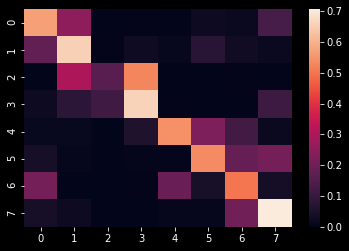

In [105]:
helper.evaluate(y_val, pred_lgb)

---
# Post Process - Discrete

In [106]:
# pred = pd.Series(pred_rf)
# pred_prob = pred_prob_rf

In [107]:
def get_pred_mode(sr):
    ct = Counter(sr).most_common()[0]
    return ct[0] if ct[1] >= 2 else sr[2]

df_res = pd.DataFrame({"rf": pred_rf, "bag": pred_bag, "lgb": pred_lgb})
df_res['pred'] = df_res.apply(lambda x: get_pred_mode(x[['rf', 'bag', 'lgb']]), axis = 1)
df_res['pred_mode'] = df_res['pred'].rolling(90, center = True).agg(lambda x: x.mode()[0]).fillna(method = 'ffill').fillna(method = 'bfill').astype('int')

In [108]:
pred = df_res['pred_mode']

In [111]:
def plot_prediction(y_true, y_pred):
    plt.figure(figsize = [20, 8])
    plt.plot(y_pred, alpha = 0.4)
    plt.plot(y_true)

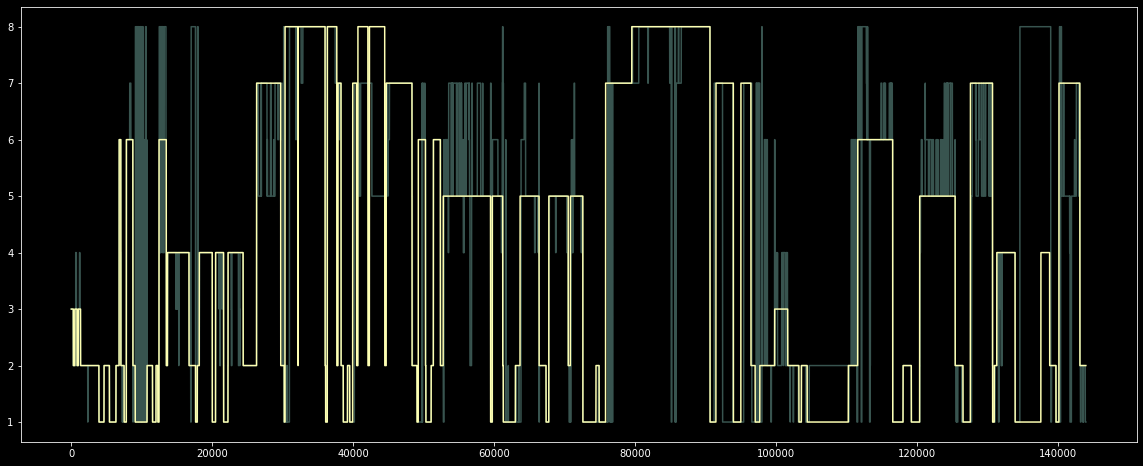

In [110]:
plot_prediction(y_val, pred)

[[19155  3426     0   107   416   826  3187   714]
 [ 5858 19642  1002   525   335    26    63   139]
 [    0    17   730   570     0     0     0     0]
 [   24    58  1002  9584   827   249    57     0]
 [    1   247     0     0 11757     0  4325  2037]
 [  256  1018    40     0  3525  5209   981   182]
 [  793   778     0     0  3586  1047 12728  3695]
 [ 3749   963     0  1245    27  1821   467 14942]]
              precision    recall  f1-score   support

       Still       0.64      0.69      0.66     27831
     Walking       0.75      0.71      0.73     27590
         Run       0.26      0.55      0.36      1317
        Bike       0.80      0.81      0.80     11801
         Car       0.57      0.64      0.61     18367
         Bus       0.57      0.46      0.51     11211
       Train       0.58      0.56      0.57     22627
      Subway       0.69      0.64      0.67     23214

    accuracy                           0.65    143958
   macro avg       0.61      0.63      0.61    14

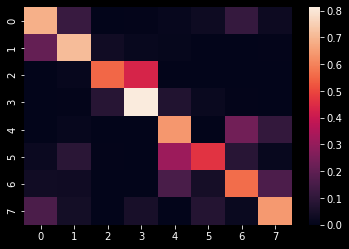

In [112]:
helper.evaluate(pred, y_val)

---
# Post Process - Continuous

- Add + mean + argmax
- Mean + add + argmax

In [125]:
window_size = 120

In [126]:
# Add + mean + argmax
pred_prob = pred_prob_rf + pred_prob_bag + pred_prob_lgb
pred_prob_mean = pd.DataFrame(pred_prob).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_mean = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[19091  6522     0    28    21   154   765  3255]
 [ 3044 19716     6    44   253  1384   694  1008]
 [    0  1151   434  1189     0     0     0     0]
 [  137   585   368  9696     0     0     0  1245]
 [  439   330     0   568 11123  4909  3043    61]
 [  856    28     0    17     0  5046  1114  2117]
 [ 3399    53     0    35  4222   243 13270   586]
 [  381   472     0     0  1982   100  3307 15467]]
              precision    recall  f1-score   support

       Still       0.70      0.64      0.67     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.54      0.16      0.24      2774
        Bike       0.84      0.81      0.82     12031
         Car       0.63      0.54      0.58     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.60      0.61      0.60     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.63      0.60      0.60    14

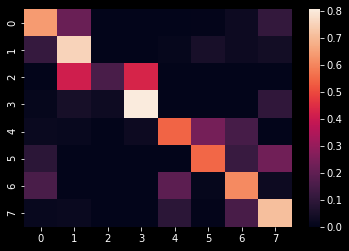

In [127]:
helper.evaluate(y_val, pred_mean)

In [130]:
# Mean + add + argmax
pred_prob_rf_mean = pd.DataFrame(pred_prob_rf).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_bag_mean = pd.DataFrame(pred_prob_bag).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')
pred_prob_lgb_mean = pd.DataFrame(pred_prob_lgb).rolling(window_size, center = True).mean().fillna(method = 'ffill').fillna(method = 'bfill')

pred_prob_mean = pred_prob_rf_mean + pred_prob_bag_mean + pred_prob_lgb_mean
pred_mean2 = pd.Series(np.array(pred_prob_mean).argmax(axis = 1) + 1)

[[19091  6522     0    28    21   154   765  3255]
 [ 3044 19716     6    44   253  1384   694  1008]
 [    0  1151   434  1189     0     0     0     0]
 [  137   585   368  9696     0     0     0  1245]
 [  439   330     0   568 11123  4909  3043    61]
 [  856    28     0    17     0  5046  1114  2117]
 [ 3399    53     0    35  4222   243 13270   586]
 [  381   472     0     0  1982   100  3307 15467]]
              precision    recall  f1-score   support

       Still       0.70      0.64      0.67     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.54      0.16      0.24      2774
        Bike       0.84      0.81      0.82     12031
         Car       0.63      0.54      0.58     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.60      0.61      0.60     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.63      0.60      0.60    14

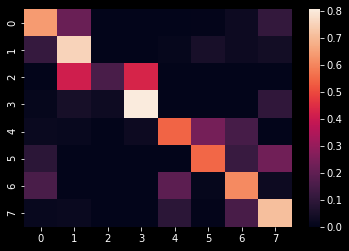

In [131]:
helper.evaluate(y_val, pred_mean2)

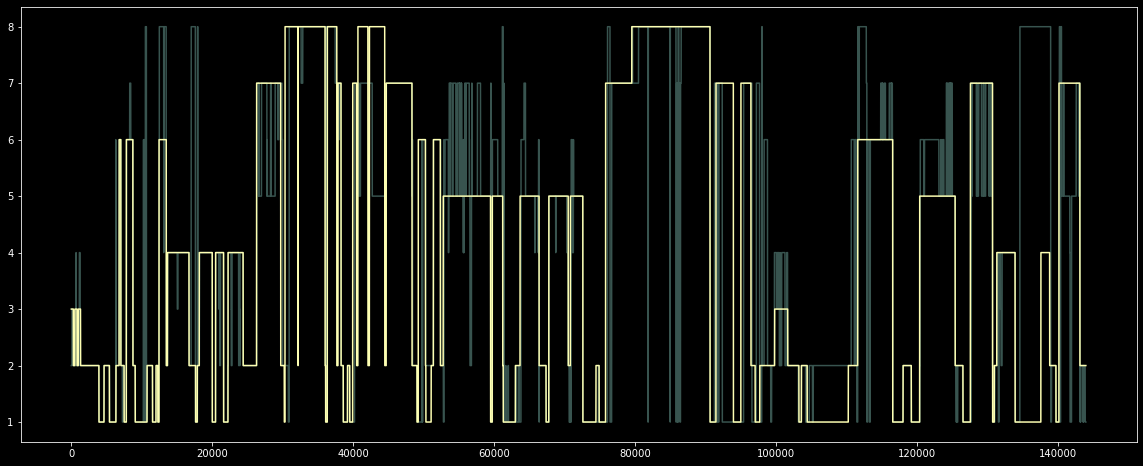

In [133]:
plot_prediction(y_val, pred_mean2)

## Rule-Based Method

- Duration Restriction
- Transition Banning

In [134]:
def get_group_conscount(sr):
    groups = groupby(sr.values.tolist())
    grouped_elements = [list(group) for key, group in groups]
    dur_df = pd.DataFrame({"label": [t[0] for t in grouped_elements],
                        "duration": [len(t) for t in grouped_elements]})
    return dur_df

In [135]:
df_dur = get_group_conscount(pred_mean2)
df_dur['cons_state_index'] = df_dur.index

In [136]:
df_res = pd.DataFrame({'pred': pred_mean2})
df_res['cons_state_index'] = (df_res['pred'].diff(1) != 0).astype('int').cumsum() - 1
df_res = pd.merge(df_res, df_dur, on = 'cons_state_index')

In [137]:
df_res['pred_last'] = df_res['pred'].shift(1).fillna(method = 'bfill').astype('int')

In [138]:
rule_time_dic = dict({1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5})

In [139]:
rule_trans_map = np.array(pd.read_table('data/transition_rule.txt', sep = ',', header = None))

In [140]:
pred_rule = df_res['pred'].copy()
for i in range(df_res.shape[0]):
    if df_res['duration'][i] < rule_time_dic[df_res['pred'][i]]:
        pred_rule[i] = df_res['pred_last'][i]
        df_res['pred_last'][i+1] = pred_rule[i]
    # transition rule
    # if rule_trans_map[df_res['pred_last'][i]-1, df_res['pred'][i]-1] == 0:
    #     pred_rule[i] = df_res['pred_last'][i]
    #     df_res['pred_last'][i+1] = pred_rule[i]

[[19098  6519     0    28    21   154   761  3255]
 [ 3046 19714     6    44   253  1384   694  1008]
 [    0  1151   435  1188     0     0     0     0]
 [  137   585   368  9696     0     0     0  1245]
 [  441   328     0   566 11130  4909  3038    61]
 [  856    28     0    17     0  5046  1114  2117]
 [ 3399    53     0    35  4225   243 13267   586]
 [  383   472     0     0  1982   100  3305 15467]]
              precision    recall  f1-score   support

       Still       0.70      0.64      0.67     29836
     Walking       0.68      0.75      0.72     26149
         Run       0.54      0.16      0.24      2774
        Bike       0.84      0.81      0.82     12031
         Car       0.63      0.54      0.58     20473
         Bus       0.43      0.55      0.48      9178
       Train       0.60      0.61      0.60     21808
      Subway       0.65      0.71      0.68     21709

    accuracy                           0.65    143958
   macro avg       0.63      0.60      0.60    14

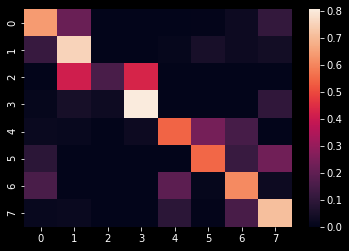

In [141]:
helper.evaluate(y_val, pred_rule)

In [142]:
df_dur2 = get_group_conscount(pred_rule)

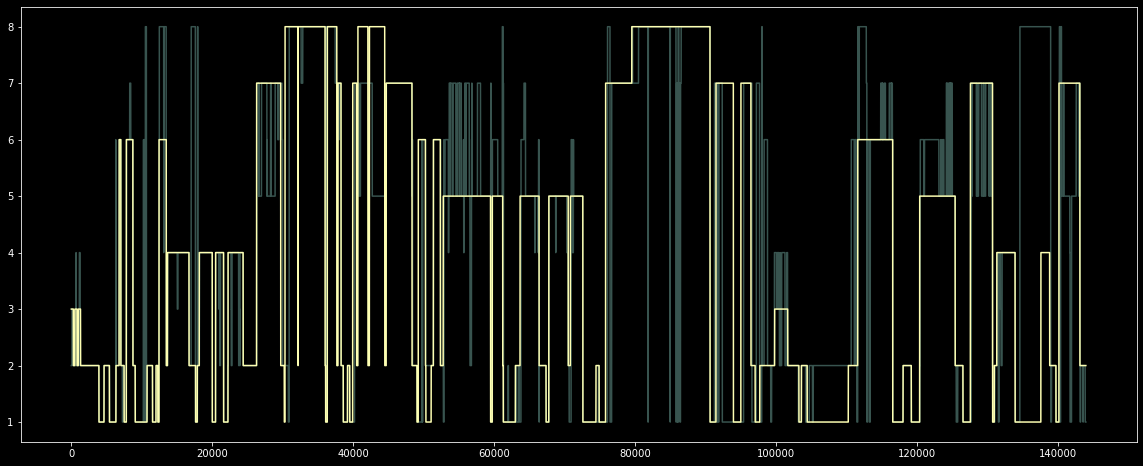

In [144]:
plot_prediction(y_val, pred_rule)

In [145]:
df_dur2.groupby('label').min()

,duration
label,
1,6
2,5
3,5
4,7
5,6
6,7
7,5
8,50


## Transition

In [173]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp

array([[ 0., 23.,  4., 21.,  8., 45., 32., 23.],
       [60.,  0., 12., 21., 15., 15., 16., 22.],
       [ 8., 11.,  0.,  6.,  6.,  3.,  2.,  0.],
       [28., 23.,  5.,  0.,  6.,  2.,  4.,  0.],
       [ 8., 11.,  7.,  8.,  0.,  0.,  0.,  0.],
       [17., 42.,  7.,  2.,  0.,  0.,  0.,  0.],
       [17., 24.,  0.,  9.,  0.,  3.,  0.,  2.],
       [18., 27.,  1.,  0.,  0.,  0.,  1.,  0.]])

[[1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 1 1 0]
 [1 1 1 1 1 0 0 0]
 [1 1 1 1 0 1 0 0]
 [1 1 0 1 0 1 1 1]
 [1 1 1 0 0 0 1 1]]


<AxesSubplot:>

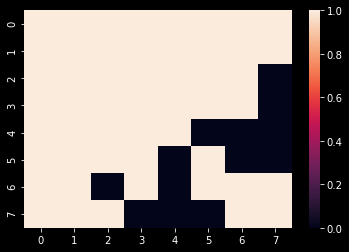

In [215]:
tmp = np.zeros([8, 8])
for i, pair in enumerate(nltk.bigrams(data.df[data.df['valid_dlt'] == 1].label)):
    if pair[0] != pair[1]:
        tmp[pair[0]-1, pair[1]-1] += 1
tmp = 1-(tmp == 0).astype('int') + np.diag([1]*8)
print(tmp)
sns.heatmap(tmp)

<AxesSubplot:>

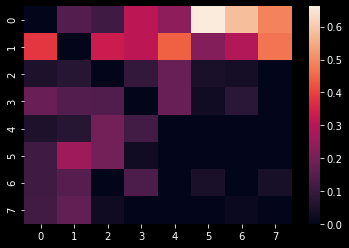

In [146]:
sns.heatmap(tmp / tmp.sum(axis = 1)) # axis = 1 求行和

In [112]:
# plt.figure(figsize = [12, 6])
# sns.boxplot(x = df_dur['label'], y = df_dur['duration'])